# Beach nourishment and dune rebuilding in CASCADE

In this notebook we test and show the functionality of the BeachNourisher module within `CASCADE`.

In [1]:
pwd

'/Users/KatherineAnardeWheels/PycharmProjects/CASCADE/notebooks'

In [2]:
import numpy as np
import sys
import time
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

# sys.path.extend(['/Users/KatherineAnardeWheels/PycharmProjects/Barrier3D', '/Users/KatherineAnardeWheels/PycharmProjects/brie', '/Users/KatherineAnardeWheels/PycharmProjects/CASCADE'])
datadir = "../B3D_Inputs/"  # laptop 
Path(datadir)
#datadir = "/Users/KatherineAnardeWheels/PycharmProjects/CASCADE/B3D_Inputs/"  # laptop

from cascade import Cascade
from scripts import CASCADE_plotters as CASCADE_Plt

Here we initialize `CASCADE` with the default wave climate and dune dynamics (average dune growth rate of 0.45), but increase the rate of sea level rise to 0.007 m/yr and simulate only one 500 m `Barrier3D` domain. All other optional modules are turned off (alongshore sediment transport from `BRIE`, community dynamics from `CHOME`, and roadway management). 

The nourishment module requires three input variables at initialization:
- `dune_design_elevation`  # dune rebuilt to this height every nourishment, unless otherwise specified
- `nourishment_interval`  # yrs
- `nourishment_volume` 

CONTINUE EXPLAINING MODEL COMPONENTS SEQUENTIALLY HERE...turn dune migration off once we nourish (we don't allow the dune line to move seaward, as with natural progradation)...where the formulation for shoreface nourishment comes from (citation and explanation).

- will need to talk about how we are essentially averaging over the relaxation time for nourishment

## OPTION 1: Nourishment and dune rebuilding at set intervals

In [3]:
# start a model by nourishing one B3D domain at discrete intervals, here we chose to start by nourishing every 15 years; 
# no roadway mgmt, otherwise default conditions except increase sea level rise to 0.005 m/yr
iB3D = 0
total_time = 100
cascade = Cascade(
    datadir,
    name="nourishment_intervals",
    sea_level_rise_rate=0.007,
    alongshore_section_count=1,
    time_step_count=total_time,
    num_cores=1,
    roadway_management_module=False,
    alongshore_transport_module=False,
    beach_nourishment_module=True,
    community_dynamics_module=False,
    dune_design_elevation=3.7,  # dune rebuilt to this height every nourishment
    nourishment_interval=15,  # yrs
    nourishment_volume=100,  # m^3/m -- 100 should produce about 20 m of shoreline progradation
)


# Loop for 50 years at a 15 year interval, 100 m^3/m and then 50 years at a 20 year interval with 300 m^3/m
nt = 50
for _ in tqdm(range(nt-1)):
    cascade.update()
    if cascade.road_break or cascade.b3d_break:
        break
        
# during the CASCADE initialization, the nourishment interval and volume is specified individually for each 
# barrier3d alongshore cell; so to update these values, we need to specify which barrier3d cell we want to modify
# (here, we only have one cell)
cascade.nourishment_interval[iB3D] = 20  # increase to 20 years
cascade.nourishment_volume[iB3D] = 300  # increase to 300 m^3/m

for _ in tqdm(range(nt)):
    cascade.update()
    if cascade.road_break or cascade.b3d_break:
        break

100%|██████████| 50/50 [00:11<00:00,  4.44it/s]


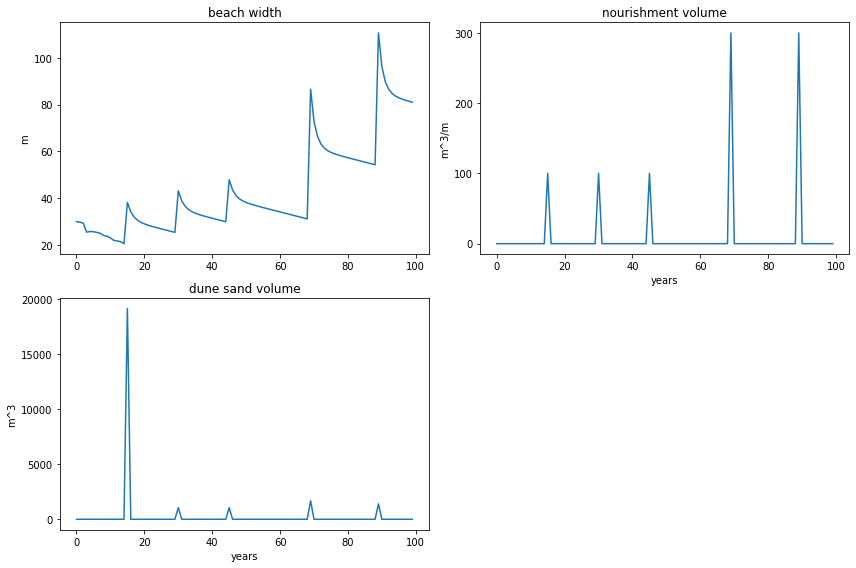

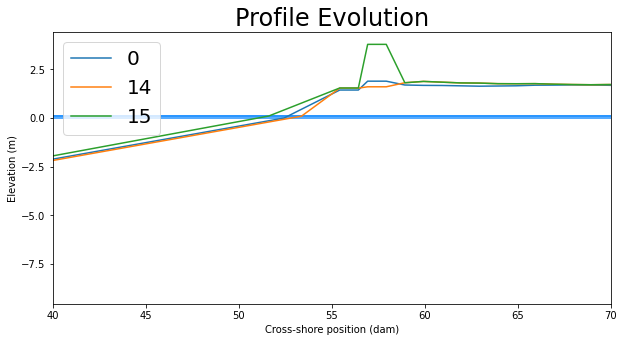

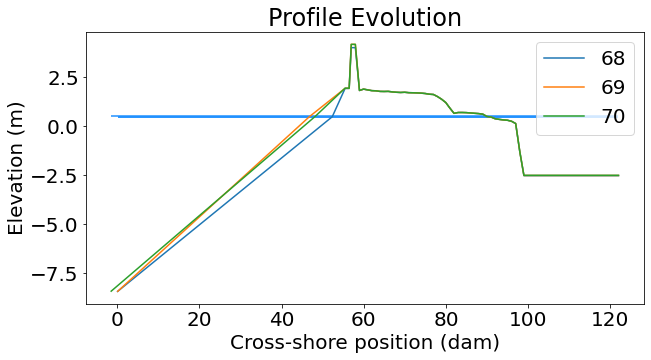

In [4]:
fig=plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.plot(cascade.nourishments[iB3D].beach_width)
plt.title("beach width")
plt.ylabel("m")

plt.subplot(2,2,2)
plt.plot(cascade.nourishments[iB3D]._nourishment_volume_TS)
plt.title("nourishment volume")
plt.ylabel("m^3/m")
plt.xlabel("years")

plt.subplot(2,2,3)
plt.plot(cascade.nourishments[iB3D]._rebuild_dune_volume_TS)
plt.title("dune sand volume")
plt.ylabel("m^3")
plt.xlabel("years")
fig.tight_layout()

time_step = [0,14,15]
fig = CASCADE_Plt.plot_ModelTransects(cascade, time_step, iB3D=0)
fig.set_xlim([40,70])
# fig.set_ylim([-1,3])

time_step = [68, 69, 70]
fig = CASCADE_Plt.plot_ModelTransects(cascade, time_step, iB3D=0)
# fig.set_xlim([50,60])
# fig.set_ylim([-1,3])

Remaining tests for Katherine: check different rates of sea level rise, add AST (want planform view for this), turn dune migration back on after <10 m beach width

## OPTION 2: Nourishment and dune rebuilding based on user indicators

In [5]:
iB3D = 0
total_time = 100
cascade = Cascade(
    datadir,
    name="nourish_now_test",
    sea_level_rise_rate=0.007,
    alongshore_section_count=1,
    time_step_count=total_time,
    num_cores=1,
    roadway_management_module=False,
    alongshore_transport_module=False,
    beach_nourishment_module=True,
    community_dynamics_module=False,
    dune_design_elevation=3.7,  # dune rebuilt to this height when specified
    nourishment_interval=None,  # yrs
    nourishment_volume=100,  # m^3/m 
)

# loop for 100 years, but after each year, check the beach width and dune height and decide if you want to nourish
# or rebuild dune the next year with nourish_now parameter
nt = 100
bw_threshold = 30  # must be greater than 10 m
dune_threshold = 0.5

for _ in tqdm(range(nt-1)):
    cascade.update()
    if cascade.road_break or cascade.b3d_break:
        break
        
    t = cascade.barrier3d[iB3D].time_index
    if cascade.nourishments[iB3D].beach_width[t-1] < bw_threshold:
        cascade.nourish_now[iB3D] = 1
        
    DuneDomainCrest = cascade.barrier3d[iB3D].DuneDomain[t-1, :, :].max(
            axis=1
        )  # Maximum height of each row in DuneDomain
    if np.mean(DuneDomainCrest) * 10 < dune_threshold:   
        cascade.rebuild_dune_now[iB3D] = 1


 45%|████▌     | 45/99 [00:58<08:10,  9.08s/it]/Users/KatherineAnardeWheels/PycharmProjects/Barrier3D/barrier3d/barrier3d.py:1360: RuntimeWarning: invalid value encountered in double_scalars
  Qs1 = Qs0 * Q1 / (Q1 + Q2 + Q3)
/Users/KatherineAnardeWheels/PycharmProjects/Barrier3D/barrier3d/barrier3d.py:1361: RuntimeWarning: invalid value encountered in double_scalars
  Qs2 = Qs0 * Q2 / (Q1 + Q2 + Q3)
/Users/KatherineAnardeWheels/PycharmProjects/Barrier3D/barrier3d/barrier3d.py:1362: RuntimeWarning: invalid value encountered in double_scalars
  Qs3 = Qs0 * Q3 / (Q1 + Q2 + Q3)
100%|██████████| 99/99 [02:59<00:00,  1.82s/it]


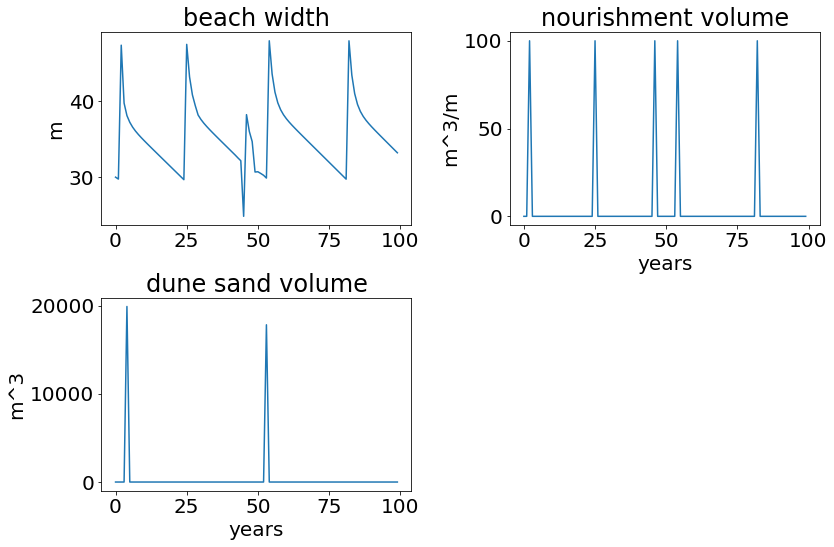

In [6]:
fig=plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.plot(cascade.nourishments[iB3D].beach_width)
plt.title("beach width")
plt.ylabel("m")

plt.subplot(2,2,2)
plt.plot(cascade.nourishments[iB3D]._nourishment_volume_TS)
plt.title("nourishment volume")
plt.ylabel("m^3/m")
plt.xlabel("years")

plt.subplot(2,2,3)
plt.plot(cascade.nourishments[iB3D]._rebuild_dune_volume_TS)
plt.title("dune sand volume")
plt.ylabel("m^3")
plt.xlabel("years")
fig.tight_layout()


So why did the nourishment volume go less far with the nourishment post storm at 46 years?

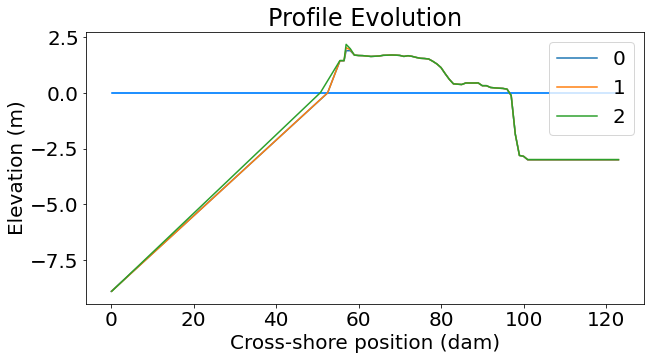

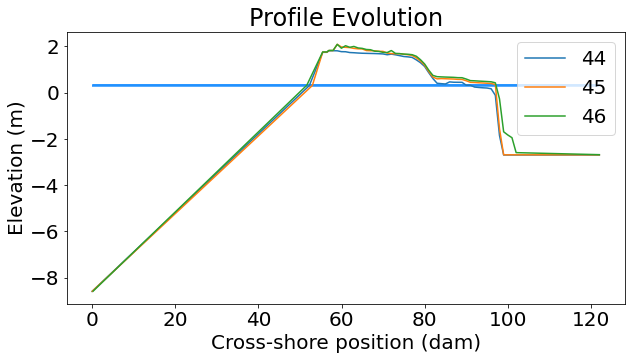

In [7]:
time_step = [0,1,2]
fig = CASCADE_Plt.plot_ModelTransects(cascade, time_step, iB3D=0)
# fig.set_xlim([40,70])
# fig.set_ylim([-1,3])

time_step = [44, 45, 46]
fig = CASCADE_Plt.plot_ModelTransects(cascade, time_step, iB3D=0)
# fig.set_xlim([50,60])

In [8]:
time_step = [45,46]
sea_level = cascade.barrier3d[iB3D]._SL  # always zero
y_shoreface = 0  # also doesn't change
# y_shoreface = (sea_level - cascade.barrier3d[iB3D].DShoreface) * 10  # also doesn't change
x_shoreface = cascade.barrier3d[iB3D]._x_t_TS 
x_shoreline = cascade.barrier3d[iB3D]._x_s_TS
# y_shoreline = sea_level
y_shoreline = cascade.barrier3d[iB3D].DShoreface * 10

area_pre_nourish = np.trapz([y_shoreface,y_shoreline], x=[x_shoreface[time_step[0]]*10, x_shoreline[time_step[0]]*10])
area_post_nourish = np.trapz([y_shoreface,y_shoreline], x=[x_shoreface[time_step[1]]*10, x_shoreline[time_step[1]]*10])
area_pre_nourish-area_post_nourish

69.27941940677647

Now that I've integrated, I'm not sure what it tells us...If we look at the equation for change in shoreline position, the only thing that differs between the two nourishments is barrier height! Create a block diagram explaining the nourishment geometry claculation. This will help explain this phenomenon.

## OPTION 3: Nourishment and dune rebuilding based on CHOME (community dynamics)

Short explanation on how nourishment and dune rebuilding/management are decided in CHOME, and how the models are coupled. Also explain new CHOME variables. Otherwise, use same inputs as above to compare!

In [9]:
iB3D = 0
total_time = 100
cascade = Cascade(
    datadir,
    name="nourish_now_test",
    sea_level_rise_rate=0.007,
    alongshore_section_count=3,  
    time_step_count=total_time,
    num_cores=1,
    roadway_management_module=False,
    alongshore_transport_module=False,
    beach_nourishment_module=True,
    community_dynamics_module=True,
    dune_design_elevation=3.7, 
    nourishment_interval=None,  
    nourishment_volume=100,  # set by CHOME, dummy variable
    number_of_communities=1, 
    sand_cost=10,
    taxratio_oceanfront=1,
    external_housing_market_value_oceanfront=6e5,
    external_housing_market_value_nonoceanfront=4e5,
    fixed_cost_beach_nourishment=2e6,
    fixed_cost_dune_nourishment=2e5,
    nourishment_cost_subsidy=10e6,
    house_footprint=15,
)

# Loop for 50 years 
nt = 50
for _ in tqdm(range(nt-1)):
    cascade.update()
    if cascade.road_break or cascade.b3d_break:
        break

 63%|██████▎   | 31/49 [45:19<26:19, 87.73s/it]  


AttributeError: can't set attribute

In [ ]:
fig=plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.plot(cascade.nourishments[iB3D].beach_width)
plt.title("beach width")
plt.ylabel("m")

plt.subplot(2,2,2)
plt.plot(cascade.nourishments[iB3D]._nourishment_volume_TS)
plt.title("nourishment volume")
plt.ylabel("m^3/m")
plt.xlabel("years")

plt.subplot(2,2,3)
plt.plot(cascade.nourishments[iB3D]._rebuild_dune_volume_TS)
plt.title("dune sand volume")
plt.ylabel("m^3")
plt.xlabel("years")
fig.tight_layout()